In [95]:
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [125]:

class MonteCarloDropoutNet:
    def __init__(self, ids):
        corpus = tf.data.Dataset.from_tensor_slices(ids)
        vectorization = tf.keras.layers.TextVectorization(
            split=None,
            max_tokens=len(ids)+2, # could be less
            output_mode="int",
            output_sequence_length=1,
            standardize=None
        )
        vectorization.adapt(corpus.batch(1024))
        print('Vocabulary: %s' % vectorization.get_vocabulary())

        input = tf.keras.Input(shape=(1,), dtype=tf.string, name="input")
        l = vectorization(input)
        l = tf.keras.layers.Embedding(vectorization.vocabulary_size(), 1, name="embedding")(l)
        l = tf.keras.layers.Dense(128, activation="relu", name="features")(l)
        l = tf.keras.layers.Dropout(0.5)(l, training=True)
        l = tf.keras.layers.Dense(1, activation="linear", name="decision")(l)
        self.model = tf.keras.models.Model(input, outputs=l, name="Net")

    def train(self, X_train, y_train, X_val, y_val):
        batch_size = int(len(X_train)/50)
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss=tf.keras.losses.MeanSquaredError()
        )

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
        mc = tf.keras.callbacks.ModelCheckpoint('best_loss', monitor='val_loss', verbose=1, mode='min', save_best_only=True)

        history = self.model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=1000,
            batch_size=batch_size,
            callbacks=[es,mc]
        )

        self.model = tf.keras.models.load_model('best_loss', compile=False)

    def predict(self, X_predict):
        return self.model.predict(X_predict, batch_size=1000)

In [126]:
train = pd.read_csv('../data/train.csv')[['id', 'val']].sample(frac=1.0)
val = pd.read_csv('../data/val.csv')[['id', 'val']].sample(frac=1.0)
test = pd.read_csv('../data/test.csv')[['id', 'val']].sample(frac=1.0)

net = MonteCarloDropoutNet(train['id'])
net.train(train['id'], train['val'], val['id'], val['val'])


Vocabulary: ['', '[UNK]', '/8', '/7', '/1', '/5', '/2', '/4', '/3', '/0', '/6', '/9']
Epoch 1/1000
40/51 [======================>.......] - ETA: 0s - loss: 0.5402
Epoch 1: val_loss improved from inf to 0.50737, saving model to best_loss
51/51 [==============================] - 2s 29ms/step - loss: 0.5259 - val_loss: 0.5074
Epoch 2/1000
47/51 [==========================>...] - ETA: 0s - loss: 0.4729
Epoch 2: val_loss improved from 0.50737 to 0.50272, saving model to best_loss
51/51 [==============================] - 2s 32ms/step - loss: 0.4723 - val_loss: 0.5027
Epoch 3/1000
43/51 [========================>.....] - ETA: 0s - loss: 0.4717
Epoch 3: val_loss did not improve from 0.50272
51/51 [==============================] - 0s 4ms/step - loss: 0.4712 - val_loss: 0.5051
Epoch 3: early stopping


In [127]:
preds = []
for i in range(0,30):
    p = net.predict(val['id'])
    preds.append(p.reshape(len(p)))
preds = np.array(preds)

2/2 [==============================] - 0s 2ms/step


In [128]:
def autotune(pred_mean, pred_std, true_val):
    onesigma = stats.norm.cdf(1, loc=0, scale=1)-stats.norm.cdf(-1, loc=0, scale=1)

    
    calibration = 0.5
    coverage = 0.0

    for i in range(0,50,1):
        calibration += 0.25
        calib_std = calibration*pred_std

        onesigma_interval = stats.norm.interval(onesigma, pred_mean, calib_std)
        pred_low = onesigma_interval[0]
        pred_high = onesigma_interval[1]
        in_interval = len(true_val[(true_val>pred_low) & (true_val<pred_high)])

        coverage = in_interval/len(true_val)

        if coverage>onesigma:
            return calibration
    

In [129]:
val['pred_mean'] = preds.mean(axis=0)
val['pred_std'] = preds.std(axis=0)

calibration = autotune(val['pred_mean'], val['pred_std'], val['val'])
print('Calibration: %.2f' % calibration)
val['calib_std'] = calibration*val['pred_std']

val

Calibration: 8.00


,id,val,pred_mean,pred_std,calib_std
176,/8,1.628265,0.850904,0.114029,0.912233
727,/8,0.632590,0.826868,0.113252,0.906017
187,/1,0.019237,-0.073245,0.057756,0.462046
115,/6,-1.580031,-0.330526,0.107720,0.861764
628,/7,-0.015496,0.290814,0.040360,0.322877
...,...,...,...,...,...
723,/8,1.687201,0.886616,0.154328,1.234624
813,/7,-0.392914,0.282229,0.057112,0.456898
6,/1,0.017882,-0.083834,0.040567,0.324536
809,/7,0.703953,0.282353,0.044259,0.354070


In [130]:
def convert_to_boxplot(means, stds):
    q1 = stats.norm.ppf(0.25, loc=means, scale=stds)
    median = stats.norm.ppf(0.5, loc=means, scale=stds)
    q3 = stats.norm.ppf(0.75, loc=means, scale=stds)
    iqr = q3-q1
    w_low = q1 - 1.5*iqr
    w_high = q3 + 1.5*iqr

    return np.array([w_low, q1, median, q3, w_high])

In [153]:
preds = []
sim = pd.DataFrame(test['id'].sort_values().unique(), columns=['id'])
for i in range(0,100):
    p = net.predict(sim['id'])
    preds.append(p.reshape(len(p)))
preds = np.array(preds)

sim['pred_mean'] = preds.mean(axis=0)
sim['pred_std'] = preds.std(axis=0)
sim['calib_std'] = calibration*sim['pred_std']

sim

1/1 [==============================] - 0s 20ms/step


,id,pred_mean,pred_std,calib_std
0,/0,0.802425,0.118667,0.949335
1,/1,-0.080757,0.048764,0.390110
2,/2,0.088811,0.038744,0.309953
3,/3,0.623474,0.095728,0.765822
4,/4,0.047941,0.032622,0.260977
5,/5,0.808335,0.118182,0.945452
6,/6,-0.345535,0.106197,0.849579
7,/7,0.288635,0.051448,0.411587
8,/8,0.860720,0.139446,1.115565
9,/9,0.715794,0.108398,0.867183


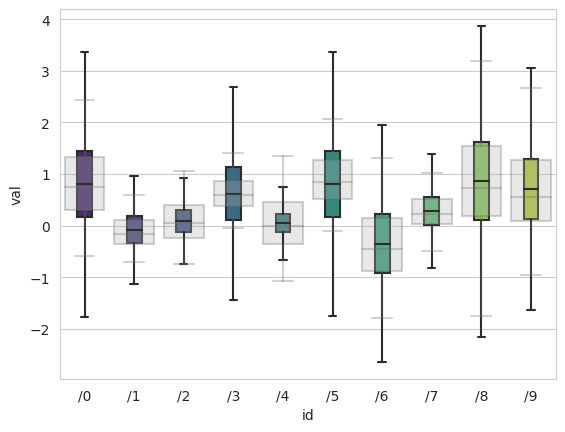

In [154]:

pred_boxplots = convert_to_boxplot(sim['pred_mean'], sim['calib_std'])

fig, ax = plt.subplots()
sns.boxplot(data=pred_boxplots, palette='viridis', width=0.3, showfliers=False)
sns.boxplot(x="id", y="val", data=test.sort_values('id'), 
    color='0.7',
    showfliers=False,
    boxprops=dict(alpha=0.3),
    medianprops=dict(alpha=0.3),
    whiskerprops=dict(alpha=0.3),
    capprops=dict(alpha=0.3),
)
plt.show()

In [155]:
dists = pd.read_csv('../data/dists.csv')

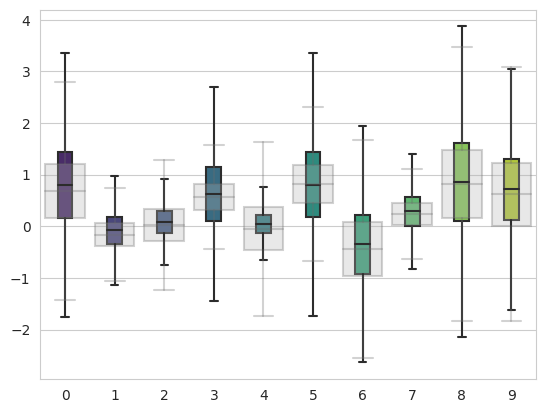

In [156]:
dists_boxplots = convert_to_boxplot(dists['loc'], dists['scale'])

fig, ax = plt.subplots()
sns.boxplot(data=pred_boxplots, palette='viridis', width=0.3, showfliers=False)
sns.boxplot(data=dists_boxplots,
    color='0.7',
    showfliers=False,
    boxprops=dict(alpha=0.3),
    medianprops=dict(alpha=0.3),
    whiskerprops=dict(alpha=0.3),
    capprops=dict(alpha=0.3),
)
plt.show()